# Trabalho 1

Grupo 5  
Filipe Barbosa A77252  
Hugo Ferreira A78555

In [1]:
import networkx as nx
import random
import math
import matplotlib.pyplot as plt
from z3 import *

### Problema 2

#### 2.a. Gerar aleatoriamente o grafo.

Começamos por dar ao problema o parâmetro número de inputs $N$, número de gates $M$, a razão $y$ entre o número de gates $add$ e restantes gates, número total de gates, output final e uma lista com os outputs de cada gate $add$.  
Calculamos agora o número de gates $add$ multiplicando a razão pelo número total, $|add| = W * y$, arredondando para cima caso não o resultado não seja um número inteiro.

In [2]:
# N = número de inputs
N = 10

# W = número de gates
W = 20

# Y = relação gates add
Y = 0.2

# outFinal
outFinal = "1010101010101010"

# len(outAdds) = nrAdd
outAdds = ["1111111111111111","0000000000000000","1111111100000000","0000000011111111"]

# nrAdd = número de gates add
# se der número nao inteiro arredonda para cima
nrAdd = math.ceil(W*Y)

# nrOutros = número de gates total - número de gates add
nrOutros = W - nrAdd

De seguida inicializa-se o grafo com auxilio da biblioteca networkx e cria-se uma lista para todos os gates.

In [3]:
# inicialização do grafo
graph = nx.Graph()

# lista para todos os gates
gatesTodos = []

Criamos $N$ inputs, adicionamos à lista $inList$ e adicionamos também ao grafo como nodes com nivel de $bipartite = 0$

In [4]:
# criar lista os inputs
inList = []
for i in range(1,N+1):
    inList.append("in-"+str(i))

# adicionar inputs no nivel 0 do grafo
graph.add_nodes_from(inList, bipartite=0)

Fazemos agora o mesmo para os gates $add$ e restantes ($xor$ e $right-shift-rotate$)

In [5]:
# criar lista com os adds
addList = []
for i in range(1,nrAdd+1):
    inp = "add-"+str(i)
    addList.append(inp)
    gatesTodos.append(inp)

# criar lista com gates não add aleatoriamente
outrosList = []
for i in range(1,nrOutros+1):
    # tipoGate = 1 é um gate XOR e tipoGate = 2 é um gate >>
    tipoGate = random.randint(1,2)
    if tipoGate == 1:
        inp = "xor-"+str(i)
        outrosList.append("xor-"+str(i))
        gatesTodos.append(inp)
    elif tipoGate == 2:
        # r numero de posicoes que faz shift
        r = random.choice([4,8,12])
        inp = ">"+str(r)+">-"+str(i)
        outrosList.append(inp)
        gatesTodos.append(inp)

# gatesTodosSemMudar tem os gates todos 
gatesTodosSemMudar = addList+outrosList
    
# adiciona os gates usados ao nivel 1 do graof
graph.add_nodes_from(gatesTodosSemMudar, bipartite=1)

Criamos uma lista to tipo $set$ (para não incluir repetidos) para os gatesUsados.
Agora, para cada input, atribui-se aleatoriamente um gate como descendente.

In [6]:
# lista com os gates ja usados
gatesUsados = set()

# atribuir descentes para cada input aleatoriamente
for i in inList:
    nd = random.randint(2,W)
    for j in range(1,nd):
        desc = random.choice(gatesTodos)
        # se sair um rotate nao pode ser mais usado
        x = desc.split("-")
        if x[0][0] == ">":
            gatesTodos.remove(desc)
        gatesUsados.add(desc)
        graph.add_edges_from([(i, desc)])

Para cada $add$ e $xor$, se apenas tiver um pai adicionamos mais um aleatoriamente.

In [7]:
# caso os add ou xor apenas tiverem um pai, adiciona outro aleatoriamente.
edges = [x[1] for x in list(graph.edges())]
edgesDic = graph.edges()
for e in edges:
    if (edges.count(e) < 2) and (e[0] == "a" or e[0] == "x"):
        rc = random.choice(inList)
        par = (rc,e)
        if par not in edgesDic:
            graph.add_edges_from([par])

Cria-se agora listas para auxilio, $gatesNaoUsados$ que contém os gates não usados no primeiro nível, $vertices$ contém todos os nodos e $gatesSemSaida$ contém os gates que ainda não foi criado output.

In [8]:
#gates nao usados no primeiro nivel
gatesNaoUsados = set(gatesTodosSemMudar) - gatesUsados
    
# todos os vertices do grafo
vertices = set(addList+outrosList)
    
# gates que ainda nao tem saida
gatesSemSaida = gatesTodosSemMudar

Inferimos agora a quantidade de gates não usados e, enquanto não forem todos utilizados, definimos aleatoriamente os gates que são pais desse. Para isso temos antes de criar o nodo com o output do pai e de seguida ligar esse nodo ao gate que ainda não foi conectado.

In [9]:
tamanho = len(gatesNaoUsados)
    
while tamanho>0:
    for i in gatesNaoUsados:
        # se e shift cria escolhe um pai, cria output desse e depois adiciona as arestas do pai para o output e do output para o shift
        if i[0] == ">":
            nd = random.randint(0,len(vertices)-1)
            n = list(vertices)[nd]
            while n==i or (n not in gatesSemSaida and len(gatesSemSaida)!=0):
                nd = random.randint(0,len(vertices)-1)
                n = list(vertices)[nd]
            if(n in gatesSemSaida):
                gatesSemSaida.remove(n)
            tamanho-=1
            graph.add_nodes_from(["out-"+str(n)], bipartite=0)
            graph.add_edges_from([(n,"out-"+str(n))])
            graph.add_edges_from([("out-"+str(n),i)])
        # se for add ou xor tem de ter pelo menos 2 pais
        else:
            nd1 = random.randint(1,len(vertices)-1)
            l = []
            while(len(l)<nd1):
                nd = random.randint(0,len(vertices)-1)
                n = list(vertices)[nd]
                while n==i or (n not in gatesSemSaida and len(gatesSemSaida)!=0):
                    nd = random.randint(0,len(vertices)-1)
                    n = list(vertices)[nd]
                if(n in gatesSemSaida):
                    l.append(n)
                    gatesSemSaida.remove(n)
                tamanho-=1
                graph.add_nodes_from(["out-"+str(n)], bipartite=0)
                graph.add_edges_from([(n,"out-"+str(n))])
                graph.add_edges_from([("out-"+str(n),i)])

Nesta fase como já foram usados todos os gates, criamos o output dos que ainda não tem e dizemos que é o $outFinal$.

In [10]:
# se ja foram usados os gates todos o output dos que não tem é o final
if tamanho<1:
    for i in gatesSemSaida:
        graph.add_edges_from([(i,outFinal)])

Finalmente desenhamos o circuito.

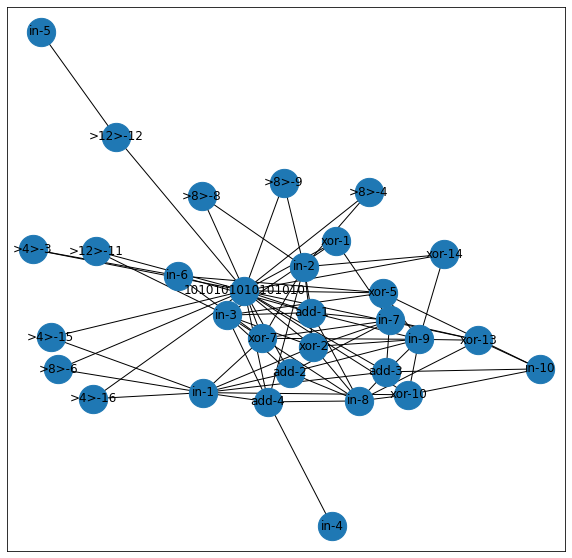

In [11]:
pos = nx.spring_layout(graph)
plt.figure(1,figsize=(10,10))
nx.draw_networkx(graph, pos, node_size=800)

#### 2.b. Determinar inputs compatíveis com output dado

Depois do circuito ser gerado utilizamos a seguinte estratégia: pegar no output final dado no inicio do problema, em seguida percorrer o grafo no sentido inverso e adicionar ao solver as condições necessárias, o que sai como output do gate é igual aos inputs desse gate aplicando a operação ai definida. Como restrição quando encontrar um gate ADD o seu output terá de ser ao igual ao elemento dado na lista $outAdds$ acima definida.

Começamos por criar duas funções para converter entre strings binárias e números inteiros, e vice versa.

In [12]:
# dada uma string de 16 bits ('0' ou '1') devolve o inteiro respectivo
def fromBin(a):
    r = 0
    for i in range(16):
        r = 2*r
        if (a[i]=='1'):
            r = r+1
    return r

# dado um inteiro devolve a string de 16 bits ('0' ou '1') com a sua representação
def toBin(a):
    r = []
    for _ in range(16):
        r.insert(0,'1' if a%2==1 else '0')
        a = a//2
    return ''.join(r)

De seguida definimos as operações utilizadas pelos gates.
Neste caso, como usamos bitVecs a operação de $add$ e $xor$ pode ser executada por uma simples soma.
Quanto ao rotate, fazemos o inverso do $right-shift-rotate$, shift de n bits para a esquerda e sabemos logo o input do gate.

In [13]:
def rotate16(a,n):
    return ((a<<n) | LShR(a,16-n))

def soma16(a,b):
    return a+b

Comecamos por atribuir aos nodos correspondentes aos outputs dos gates $add$ os respetivos valores e mudamos os nomes no circuito.
Inicializamos o solver. Determinamos todas as arestas do grafo e adicionamos a uma lista gates que tem ligação com o output final.
Percorremos a lista, inferimos os inputs desse gate e aplicamos a função adequada ao gate.

In [14]:
def calcula(graph,output,gates_output):
    graph=nx.relabel_nodes(graph,gates_output)
    
    sol=Solver()

    edges = [x for x in list(graph.edges())]
    
    l=[]
    for i in edges:
        if(i[1]==fromBin(output)):
            l.append(i[0])
    
    for i in l:
        listA=[]
        for x in edges:
            if(x[1]==i):
                listA.append(x[0])
        for y in listA:
            print(y)
            if(i[0]==">"):
                print(len(y))
                z=rotate16(output,int(i[1]))
                sol.add(z==BitVecVal(fromBin(output),16))
            else:
                z=Sum(listA)
                sol.add(z==BitVecVal(fromBin(output),16))
    print(sol)

y={}
for i in range(nrAdd):
    y["out-add-"+str(i+1)] = outAdds[i]
calcula(graph,outFinal,y)

[]


Não conseguimos concluir este ultimo problema, porque apesar de acharmos que a estratégia estar correta, e várias tentativas de diferentes condições para o solver não conseguimos, em tempo util chegar a uma solução correta.